## **Notebook PC#07**
## Self-Organizing Map (SOM) for the Travelling Salesperson Problem (TSP)<BR>
Code based on [this content](https://github.com/diego-vicente/som-tsp). <BR>

**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):** Gabriel Toffanetto França da Rocha - 289320<br>
**Aluno(a):** Maria Fernanda Paulino Gomes - 206745<br>

In [ ]:
# plot.py
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_network(cities, neurons, name='diagram.png', ax=None):
    """Plot a graphical representation of the problem"""
    mpl.rcParams['agg.path.chunksize'] = 10000

    if not ax:
        fig = plt.figure(figsize=(5, 5), frameon = False)
        axis = fig.add_axes([0,0,1,1])

        axis.set_aspect('equal', adjustable='datalim')
        plt.axis('off')

        axis.scatter(cities['x'], cities['y'], color='red', s=4)
        axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)

        plt.savefig(name, bbox_inches='tight', pad_inches=0, dpi=200)
        plt.close()

    else:
        ax.scatter(cities['x'], cities['y'], color='red', s=4)
        ax.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)
        return ax

def plot_route(cities, route, name='diagram.png', ax=None):
    """Plot a graphical representation of the route obtained"""
    mpl.rcParams['agg.path.chunksize'] = 10000

    if not ax:
        fig = plt.figure(figsize=(5, 5), frameon = False)
        axis = fig.add_axes([0,0,1,1])

        axis.set_aspect('equal', adjustable='datalim')
        plt.axis('off')

        axis.scatter(cities['x'], cities['y'], color='red', s=4)
        route = cities.reindex(route)
        route.loc[route.shape[0]] = route.iloc[0]
        axis.plot(route['x'], route['y'], color='purple', linewidth=1)

        plt.savefig(name, bbox_inches='tight', pad_inches=0, dpi=200)
        plt.close()

    else:
        ax.scatter(cities['x'], cities['y'], color='red', s=4)
        route = cities.reindex(route)
        route.loc[route.shape[0]] = route.iloc[0]
        ax.plot(route['x'], route['y'], color='purple', linewidth=1)
        return ax

In [ ]:
# neuron.py
import numpy as np

def generate_network(size):
    """
    Generate a neuron network of a given size.

    Return a vector of two dimensional points in the interval [0,1].
    """
    return np.random.rand(size, 2)

def get_neighborhood(center, radix, domain):
    """Get the range gaussian of given radix around a center index."""

    # Impose an upper bound on the radix to prevent NaN and blocks
    if radix < 1:
        radix = 1

    # Compute the circular network distance to the center
    deltas = np.absolute(center - np.arange(domain))
    distances = np.minimum(deltas, domain - deltas)

    # Compute Gaussian distribution around the given center
    return np.exp(-(distances*distances) / (2*(radix*radix)))

def get_route(cities, network):
    """Return the route computed by a network."""
    cities['winner'] = cities[['x', 'y']].apply(
        lambda c: select_closest(network, c),
        axis=1, raw=True)

    return cities.sort_values('winner').index

In [ ]:
# io_helper.py
import pandas as pd

def read_tsp(filename):
    """
    Read a file in .tsp format into a pandas DataFrame

    The .tsp files can be found in the TSPLIB project. Currently, the library
    only considers the possibility of a 2D map.
    """
    with open(filename) as f:
        node_coord_start = None
        dimension = None
        lines = f.readlines()

        # Obtain the information about the .tsp
        i = 0
        while not dimension or not node_coord_start:
            line = lines[i]
            if line.startswith('DIMENSION :'):
                dimension = int(line.split()[-1])
            elif line.startswith('DIMENSION:'):
                dimension = int(line.split()[-1])
            if line.startswith('NODE_COORD_SECTION'):
                node_coord_start = i
            i = i+1

        print('Problem with {} cities read.'.format(dimension))

        f.seek(0)

        # Read a data frame out of the file descriptor
        cities = pd.read_csv(
            f,
            skiprows=node_coord_start + 1,
            sep=' ',
            names=['city', 'y', 'x'],
            dtype={'city': str, 'x': np.float64, 'y': np.float64},
            header=None,
            nrows=dimension,
            skipinitialspace=True
        )

        # cities.set_index('city', inplace=True)

        return cities

def normalize(points):
    """
    Return the normalized version of a given vector of points.

    For a given array of n-dimensions, normalize each dimension by removing the
    initial offset and normalizing the points in a proportional interval: [0,1]
    on y, maintining the original ratio on x.
    """
    ratio = (points.x.max() - points.x.min()) / (points.y.max() - points.y.min()), 1
    ratio = np.array(ratio) / max(ratio)
    norm = points.apply(lambda c: (c - c.min()) / (c.max() - c.min()))
    return norm.apply(lambda p: ratio * p, axis=1)

In [ ]:
# distance.py

def select_closest(candidates, origin):
    """Return the index of the closest candidate to a given point."""
    return euclidean_distance(candidates, origin).argmin()

def euclidean_distance(a, b):
    """Return the array of distances of two numpy arrays of points."""
    return np.linalg.norm(a - b, axis=1)

def route_distance(cities):
    """Return the cost of traversing a route of cities in a certain order."""
    points = cities[['x', 'y']]
    distances = euclidean_distance(points, np.roll(points, 1, axis=0))
    return np.sum(distances)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Colab Notebooks/PC06-12/

Mounted at /content/drive/
[Errno 2] No such file or directory: '/content/drive/My Drive/Colab Notebooks/PC06-12/'
/content


In [ ]:
# main.py

def main():

    problem = read_tsp('qa194.tsp')

    route = som(problem, 100000)

    problem = problem.reindex(route)

    distance = route_distance(problem)

    print('Route found of length {}'.format(distance))


def som(problem, iterations, learning_rate=0.8):
    """Solve the TSP using a Self-Organizing Map."""

    # Obtain the normalized set of cities (w/ coord in [0,1])
    cities = problem.copy()

    cities[['x', 'y']] = normalize(cities[['x', 'y']])

    # The population size is 8 times the number of cities
    n = cities.shape[0] * 8

    # Generate an adequate network of neurons:
    network = generate_network(n)
    print('Network of {} neurons created. Starting the iterations:'.format(n))

    for i in range(iterations):
        if not i % 100:
            print('\t> Iteration {}/{}'.format(i, iterations), end="\r")
        # Choose a random city
        city = cities.sample(1)[['x', 'y']].values
        winner_idx = select_closest(network, city)
        # Generate a filter that applies changes to the winner's gaussian
        gaussian = get_neighborhood(winner_idx, n//10, network.shape[0])
        # Update the network's weights (closer to the city)
        network += gaussian[:,np.newaxis] * learning_rate * (city - network)
        # Decay the variables
        learning_rate = learning_rate * 0.99997
        n = n * 0.9997

        # Check for plotting interval
        if not i % 2000:
          if i > 0:
            plot_network(cities, network, name='{:05d}.png'.format(i))

        # Check if any parameter has completely decayed.
        if n < 1:
            print('Radius has completely decayed, finishing execution',
            'at {} iterations'.format(i))
            break
        if learning_rate < 0.001:
            print('Learning rate has completely decayed, finishing execution',
            'at {} iterations'.format(i))
            break
    else:
        print('Completed {} iterations.'.format(iterations))

    plot_network(cities, network, name='final.png')

    route = get_route(cities, network)
    plot_route(cities, route, 'route.png')
    return route

if __name__ == '__main__':
    main()

Problem with 194 cities read.
Network of 1552 neurons created. Starting the iterations:


<ipython-input-37-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-37-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-37-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-37-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-37-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-37-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-37-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-37-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-37-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-37-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-37-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-37-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


Radius has completely decayed, finishing execution at 24487 iterations


<ipython-input-37-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


Route found of length 9888.353194919491


In [ ]:
problem = read_tsp('qa194.tsp')
with pd.option_context('display.max_rows', None,):
    print(problem)

Problem with 194 cities read.
    city           y           x
0      1  24748.3333  50840.0000
1      2  24758.8889  51211.9444
2      3  24827.2222  51394.7222
3      4  24904.4444  51175.0000
4      5  24996.1111  51548.8889
5      6  25010.0000  51039.4444
6      7  25030.8333  51275.2778
7      8  25067.7778  51077.5000
8      9  25100.0000  51516.6667
9     10  25103.3333  51521.6667
10    11  25121.9444  51218.3333
11    12  25150.8333  51537.7778
12    13  25158.3333  51163.6111
13    14  25162.2222  51220.8333
14    15  25167.7778  51606.9444
15    16  25168.8889  51086.3889
16    17  25173.8889  51269.4444
17    18  25210.8333  51394.1667
18    19  25211.3889  51619.1667
19    20  25214.1667  50807.2222
20    21  25214.4444  51378.8889
21    22  25223.3333  51451.6667
22    23  25224.1667  51174.4444
23    24  25233.3333  51333.3333
24    25  25234.1667  51203.0556
25    26  25235.5556  51330.0000
26    27  25235.5556  51495.5556
27    28  25242.7778  51428.8889
28    29  252

In [ ]:
# Code based on: https://stackoverflow.com/questions/41228209/making-gif-from-images-using-imageio-in-python
import os
import imageio

png_dir = '.'
images = []
for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))

# Make it pause at the end so that the viewers can ponder
for _ in range(10):
    images.append(imageio.imread(file_path))

imageio.mimsave('movie.gif', images)

<ipython-input-44-a7086ab0b9b2>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))
<ipython-input-44-a7086ab0b9b2>:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


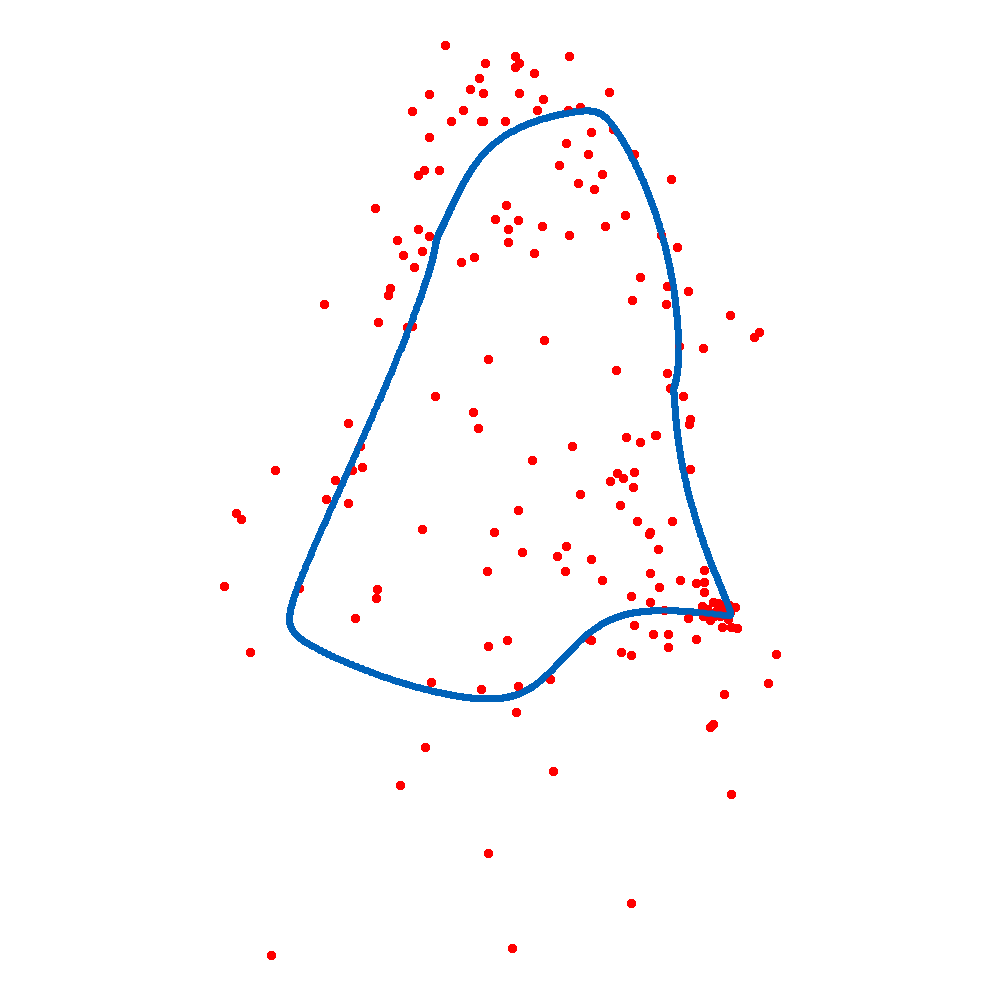

In [ ]:
from IPython.display import Image

Image('movie.gif', width=500, height=500)

Instruções para a atividade seguinte: Após concluir a execução das células anteriores, escolha alguma nova instância de TSP disponível
[aqui](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/), carregue o respectivo arquivo no ambiente Colab, apague os atuais arquivos [*.png] com o comando a seguir e execute as células na sequência, incluindo o nome do arquivo que você escolheu no local devido, o qual contém as coordenadas das cidades.

In [ ]:
!rm *.png

In [ ]:
# main2.py

def main():

    problem2 = read_tsp('ch130.tsp') # Please, insert here the new filename.

    route2 = som(problem2, 100000)

    problem2 = problem2.reindex(route2)

    distance2 = route_distance(problem2)

    print('Route found of length {}'.format(distance2))


def som(problem, iterations, learning_rate=0.8):
    """Solve the TSP using a Self-Organizing Map."""

    # Obtain the normalized set of cities (w/ coord in [0,1])
    cities = problem.copy()

    cities[['x', 'y']] = normalize(cities[['x', 'y']])

    # The population size is 8 times the number of cities
    n = cities.shape[0] * 8

    # Generate an adequate network of neurons:
    network = generate_network(n)
    print('Network of {} neurons created. Starting the iterations:'.format(n))

    for i in range(iterations):
        if not i % 100:
            print('\t> Iteration {}/{}'.format(i, iterations), end="\r")
        # Choose a random city
        city = cities.sample(1)[['x', 'y']].values
        winner_idx = select_closest(network, city)
        # Generate a filter that applies changes to the winner's gaussian
        gaussian = get_neighborhood(winner_idx, n//10, network.shape[0])
        # Update the network's weights (closer to the city)
        network += gaussian[:,np.newaxis] * learning_rate * (city - network)
        # Decay the variables
        learning_rate = learning_rate * 0.99997
        n = n * 0.9997

        # Check for plotting interval
        if not i % 2000:
          if i > 0:
            plot_network(cities, network, name='{:05d}.png'.format(i))

        # Check if any parameter has completely decayed.
        if n < 1:
            print('Radius has completely decayed, finishing execution',
            'at {} iterations'.format(i))
            break
        if learning_rate < 0.001:
            print('Learning rate has completely decayed, finishing execution',
            'at {} iterations'.format(i))
            break
    else:
        print('Completed {} iterations.'.format(iterations))

    plot_network(cities, network, name='final.png')

    route = get_route(cities, network)
    plot_route(cities, route, 'route.png')
    return route

if __name__ == '__main__':
    main()

Problem with 130 cities read.
Network of 1040 neurons created. Starting the iterations:


<ipython-input-37-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-37-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-37-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-37-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-37-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-37-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-37-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-37-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-37-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-37-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-37-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


Radius has completely decayed, finishing execution at 23153 iterations


<ipython-input-37-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


Route found of length 6305.902523422533


In [ ]:
problem2 = read_tsp('ch130.tsp') # Please, insert here the new filename.
with pd.option_context('display.max_rows', None,):
    print(problem2)

Problem with 130 cities read.
    city           y           x
0      1  334.590925  161.780932
1      2  397.644663  262.816533
2      3  503.874183  172.874115
3      4  444.047940  384.649181
4      5  311.613715    2.009170
5      6  662.855101  549.230126
6      7   40.097903  187.237543
7      8  526.894141  215.707909
8      9  209.188794  691.026229
9     10  683.267413  414.209629
10    11  280.749444    5.920639
11    12  252.749309  535.743039
12    13  698.785045  348.441373
13    14  678.757468  410.725642
14    15  220.004113  409.122581
15    16  355.152856   76.391208
16    17  296.972423  313.131279
17    18  504.515407  240.886656
18    19  224.107950  358.487223
19    20  470.680130  309.625919
20    21  554.253051  279.424247
21    22  567.633268  352.716203
22    23  599.053267  361.094869
23    24  240.523296  430.603601
24    25   32.082597  345.855101
25    26   91.053874  148.721327
26    27  248.217989  343.952802
27    28  488.890904    3.612231
28    29  206

In [ ]:
# Code based on: https://stackoverflow.com/questions/41228209/making-gif-from-images-using-imageio-in-python
import os
import imageio

png_dir = '.'
images = []
for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))

# Make it pause at the end so that the viewers can ponder
for _ in range(10):
    images.append(imageio.imread(file_path))

imageio.mimsave('movie2.gif', images)

<ipython-input-50-52db64c8304d>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))
<ipython-input-50-52db64c8304d>:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


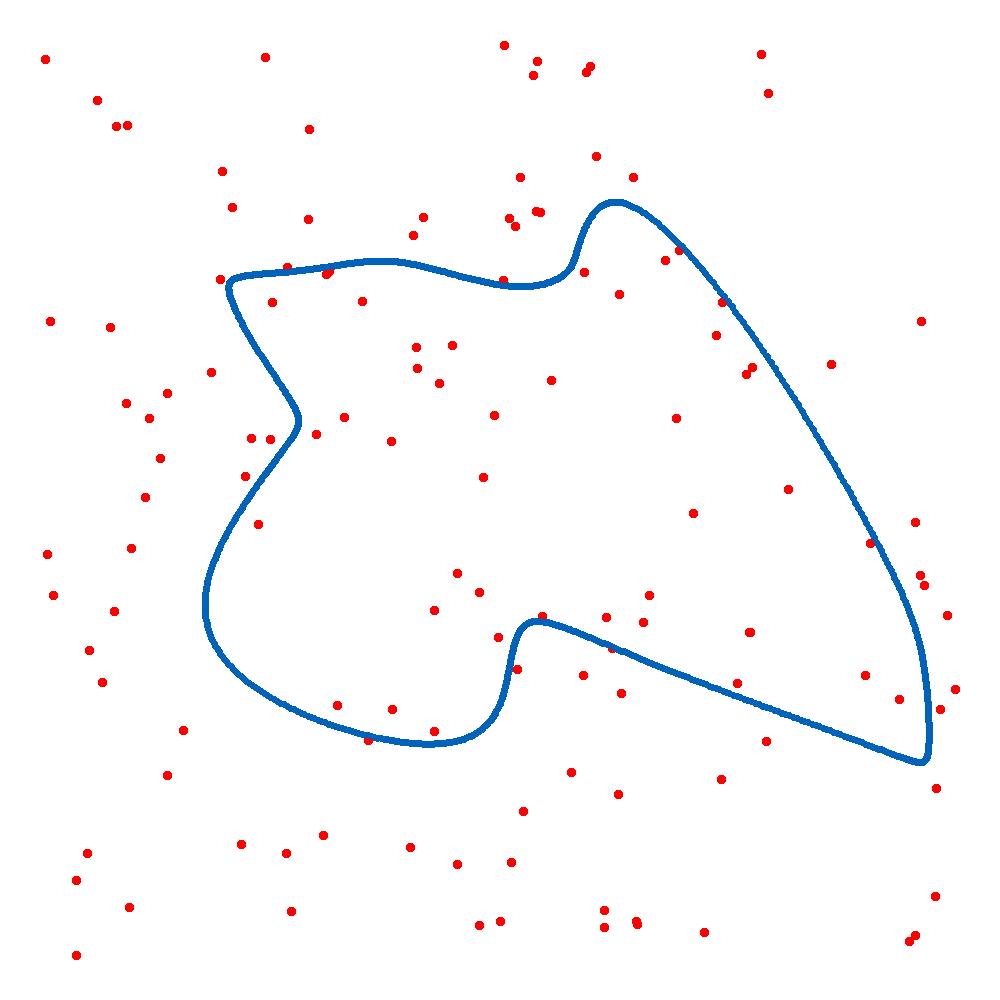

In [ ]:
Image('movie2.gif', width=500, height=500)

## Questão (a)

O princípio da operação da técnica do mapa auto-organizável (SOM) unidimensional para resolver o problema do caixeiro-viajante envolve a organização dos neurônios em um anel elástico que se adapta às coordenadas da cidade. Cada neurônio representa uma cidade, e o anel se ajusta através de um processo iterativo onde os neurônios são atraídos pelas cidades, minimizando o perímetro do anel. A taxa de apresndizado e a vizinhança decrescem com o tempo, garantindo a convergência do algoritmo para uma solução subótima.

## Questão (b)

### Computador Digital

Utilizando hardware de Von Neumann, o problema do caixeiro viajante tem característica combinacional, sendo um problema NP-hard, devido à sua complexidade fatorial, com um espaço de busca de ordem $(N-1)!/2$. Ele é comummente resolvido por meio de *solvers*, como o Concorde TSP Solver.

### Rede de Hopfield

O problema do caixeiro viajante é tomado como o problema da definição de uma superfície de energia para um sistema dinâmico não linear, onde dado os hiperparâmetros $A$, $B$, $C$ e $D$, se define o espaço de estados que tem como ponto de equilíbrio a solução do TSP. A solução é concebida por uma rede de Hopfield com $N^2$ neurônios, com seus pesos dados pelos hiperparâmetros citados anteriormente, onde após a convergência por relaxação dada uma condição inicial aleatória, monta-se um *grid* $N \times N$ com os neurônios, onde somente um deverá estar ativo para cada linha e coluna. Dado isto, se lê coluna a coluna da matriz de neurônios, onde o índice da linha do neurônio ativo em cada coluna formam uma lista com a ordem das cidades que devem ser percorridas, ou seja, a solução do problema.

### Mapa de Kohonen

Considerando a distribuição das cidades no plano 2D do mundo, a solução utilizando o mapa de Kohonen unidimensional configurado como um anel, se da em dispersar os neurônios sobre o plano 2D de forma que eles estejam entre os dados. A partir disso, realiza-se o processo de auto-organização do mapa, onde as cidades atraem os neurônios do mapa até que os mesmos estejam interligando todas as cidades, gerando assim um laço entre todas elas é que a solução do problema.

## Questão (c)

Ter disponíveis *hardwares* alternativos, como por exemplo computadores quânticos ou GPUs especializadas, pode impactar a resolução do problema do caixeiro viajante de várias maneiras, como por exemplo:

1. Na velocidade de cálculo, uma vez que *hardwares* avançados possuem a capacidade de executar algoritmos muito mais rapidamente, reduzindo então o tempo necessário para encontrar soluções ótimas;
2. Tecnologias como computação quântica permitem a implementação de algoritmos que não são viáveis em computadores clássicos, potencialmente encontrando soluções mais eficientes para o problema do caixeiro viajante.
3. *Hardwares* especializados possuem maior capacidade de lidar com problemas de grande escala, permitindo resolver instâncias do problema do caixeiro viajante com um número mais de cidade de forma prática.
4. Além disso, processadores mais eficientes podem reduzir o consumo de energia, tornando a resolução de problemas mais complexos mais eficientes.

Além disso, ao obter *hardwares* especializados para neuro-computadores, permite que a concepção da solução do problema do TSP seja implementado por redes neurais, como o Mapa de Kohonen ou Rede de Hopfield como realmente é, ou seja, como estruturas que operam em paralelo e com isso apresentam um desempenho considerável, reduzindo tempo de processamento e produzindo um desempenho elevado, sem os gargalos da solução necessitar de ser simulada em outro tipo de *hardware*, como o computador digital.



